# CRTBP en Sistemas Astronómicos

In [2]:
from numpy import *
from scipy.optimize import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from numpy.linalg import norm
%matplotlib inline
DEG=pi/180
RAD=180/pi

# Ecuaciones de Movimiento

In [3]:
def eom(q,t,mu):
    r1=array([-mu,0,0])
    r2=array([1-mu,0,0])
    omega=array([0,0,1])
    
    r=q[:3]
    v=q[3:]
    
    R1=r-r1
    R2=r-r2
    
    drdt=v
    dvdt=-(1-mu)/norm(R1)**3*R1-mu/norm(R2)**3*R2-cross(omega,cross(omega,r))-2*cross(omega,v)
    
    dqdt=drdt.tolist()+dvdt.tolist()
    
    return dqdt

def JacobiConstant(r,v,mu):
    r1=array([-mu,0,0])
    r2=array([1-mu,0,0])
    omega=array([0,0,1])
    
    R1=r-r1
    R2=r-r2
    
    C=norm(v)**2-2*(1-mu)/norm(R1)-2*mu/norm(R2)-(r[0]**2+r[1]**2)
    return C

# Matriz de Rotación
def rotationMatrix(t,axis):
    R=identity(3)
    r=array([[cos(t),sin(t)],[-sin(t),cos(t)]])
    if axis=='z':R[0:2,0:2]=r
    elif axis=='x':R[1:3,1:3]=r
    else:
        R[0,0]=r[0,0];R[0,2]=r[0,1]
        R[2,0]=r[1,0];R[2,2]=r[1,1]
    return R

# Asteroides Griegos y Troyanos

In [4]:
# Sistema Sol-Júpiter-Asteroide
mu=1e-3

# Puntos de Equilibrio
L4=array([cos(60*DEG)-mu,sin(60*DEG),0])
L5=array([cos(60*DEG)-mu,-sin(60*DEG),0])

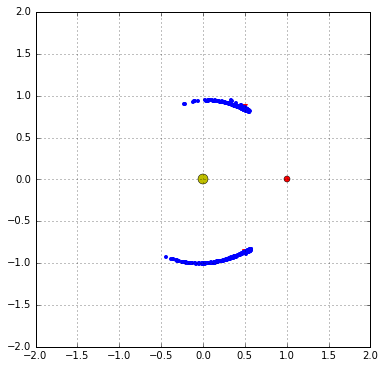

In [5]:
# Inicializa gráfico
fig=plt.figure(figsize=(6,6))
ax=fig.gca()
ax.plot([-mu],[0],'yo',markersize=10)
ax.plot([1-mu],[0],'ro')
ax.plot(L4[0],L4[1],'rv',markeredgecolor='none')
ax.plot(L5[0],L5[1],'rv',markeredgecolor='none')

# Asteroides
Na=500
Nt=1000
ts=linspace(0,30.0,1000)
for i in xrange(Na):
    
    # Choose equilibrium point
    u=random.random()
    
    # Initial conditions
    dr=0.01*random.random((3,1))[:,0]
    if u<0.5:r=L4+dr
    else:r=L5+dr
    dv=0.01*random.random((3,1))[:,0]
    v=array([0,0,0])+dv
    
    # Orbit integration
    q=r.tolist()+v.tolist()
    solution=odeint(eom,q,ts,args=(mu,))
    rs=solution[:,:3]
    vs=solution[:,3:]
    
    # Plotting solution
    ax.plot(rs[-1,0],rs[-1,1],'bo',markeredgecolor='none',markersize=4)
    
ext=2
ax.set_xlim((-ext,ext))
ax.set_ylim((-ext,ext))
ax.grid()
    

# Orbita de un cometa

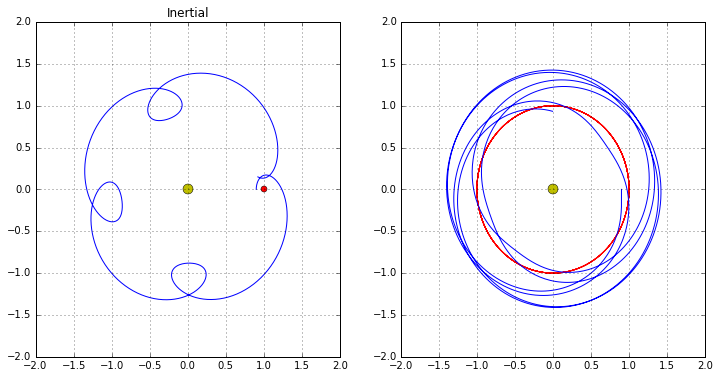

In [6]:
# Condiciones iniciales del cometa
r=array([0.9,0,0])
v=array([0,0.3,0.1])

# Solución
Nt=1000
ts=linspace(0,30.0,1000)
q=r.tolist()+v.tolist()
solution=odeint(eom,q,ts,args=(mu,))
rs=solution[:,:3]
vs=solution[:,3:]

# Transformación al sistema no rotante
ris=zeros_like(rs)
vis=zeros_like(vs)
for i in xrange(Nt):
    ris[i]=rotationMatrix(ts[i],'z').dot(rs[i])
    vis[i]=vs[i]+cross(array([0,0,1]),rs[i])

# Gráfica del movimiento en el sistema rotante
fig=plt.figure(figsize=(12,6))
axr=fig.add_subplot(1,2,1)
axi=fig.add_subplot(1,2,2)

# Rotante
axr.plot(rs[:,0],rs[:,1])
axr.plot([-mu],[0],'yo',markersize=10)
axr.plot([1-mu],[0],'ro')

# No rotante
axi.plot([-mu],[0],'yo',markersize=10)
axi.plot(cos(ts),sin(ts),'r-',markersize=10)
axi.plot(ris[:,0],ris[:,1])

axr.set_title("Rotating")
axr.set_title("Inertial")

ext=2
for ax in axr,axi:
    ax.set_xlim((-ext,ext))
    ax.set_ylim((-ext,ext))
    ax.grid()

# Evolución de los elementos orbitales

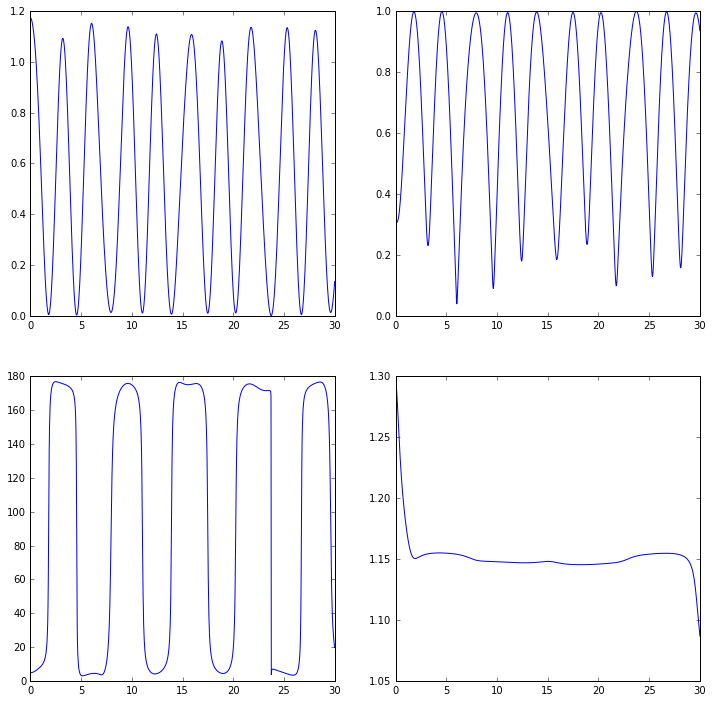

In [8]:
# Momento angular y vector de excentricidad
ps=[]
es=[]
ies=[]
aes=[]
for i in xrange(Nt):
    r=ris[i]
    v=vis[i]
    h=cross(r,v)
    evec=cross(v,h)-r/norm(r)
    e=norm(evec)
    p=norm(h)**2

    # Elementos orbitales
    ps+=[norm(h)**2]
    es+=[e]
    ies+=[arccos(h[2]/norm(h))*RAD]
    aes+=[p/(1-e**2)]
    
ps=array(ps);es=array(es);ies=array(ies);aes=array(aes)
    
fig=plt.figure(figsize=(12,12))
axp=fig.add_subplot(2,2,1)
axe=fig.add_subplot(2,2,2)
axi=fig.add_subplot(2,2,3)
axa=fig.add_subplot(2,2,4)

axp.plot(ts,ps)
axe.plot(ts,es)
axi.plot(ts,ies)
axa.plot(ts,aes)

# El parámetro de Tisserand

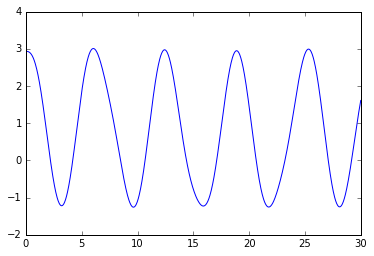

In [9]:
# Parametro de Tisserand
C = 1/aes+2*sqrt(aes*(1-es**2))*cos(ies*DEG)

plt.plot(ts,C)